# Setup:

### Import necessary libraries

In [ ]:
import warnings
# Ignore all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Suppress all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, ImageColorGenerator
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.layers import GaussianNoise
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
import pandas as pd
import math
from matplotlib import pyplot as plt
import os
import pickle
import random
from tensorflow.python.ops.numpy_ops import np_config
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report, f1_score
import seaborn as sns

np_config.enable_numpy_behavior()

In [ ]:
# function to plot curves and calculate metrics
def plot_and_print(history, model, X_train, y_train, X_test, y_test):
    # Set the figure size for both plots
    plt.figure(figsize=(8, 4))

    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

    # Evaluation on the train set
    train_loss, train_acc = model.evaluate(X_train, y_train)
    print(f"Train accuracy: {train_acc:.3f}")
    y_train_pred_prob = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred_prob, axis=-1)
    train_precision = precision_score(np.argmax(y_train, axis=1), y_train_pred, average='weighted')
    train_recall = recall_score(np.argmax(y_train, axis=1), y_train_pred, average='weighted')
    train_f1 = f1_score(np.argmax(y_train, axis=1), y_train_pred, average='weighted')
    print(f"Train precision: {train_precision:.3f}")
    print(f"Train recall: {train_recall:.3f}")
    print(f"Train F1 score: {train_f1:.3f}")

    # Evaluation on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {test_acc:.3f}")
    y_test_pred_prob = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_prob, axis=-1)
    test_precision = precision_score(np.argmax(y_test, axis=1), y_test_pred, average='weighted')
    test_recall = recall_score(np.argmax(y_test, axis=1), y_test_pred, average='weighted')
    test_f1 = f1_score(np.argmax(y_test, axis=1), y_test_pred, average='weighted')
    print(f"Test precision: {test_precision:.3f}")
    print(f"Test recall: {test_recall:.3f}")
    print(f"Test F1 score: {test_f1:.3f}")

    # Creating subplots for confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Plotting confusion matrix for the train set
    cm_train = confusion_matrix(np.argmax(y_train, axis=1), y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3), ax=axes[0])
    axes[0].set_title('Confusion Matrix - Train Set')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Plotting confusion matrix for the test set
    cm_test = confusion_matrix(np.argmax(y_test, axis=1), y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3), ax=axes[1])
    axes[1].set_title('Confusion Matrix - Test Set')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    # Classification report for train and test sets
    print("Classification Report - Train Set")
    print(classification_report(np.argmax(y_train, axis=1), y_train_pred))

    print("Classification Report - Test Set")
    print(classification_report(np.argmax(y_test, axis=1), y_test_pred))

In [ ]:
# using variable learning rate for all models
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 1, min_lr = 0.0000001)

# using checpointing to save the best trained weights
cnn_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'cnn.x',
    save_best_only = True,
    monitor = 'val_loss')

rnn_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'rnn.x',
    save_best_only = True,
    monitor = 'val_loss')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load the dataset:

In [ ]:
# Load the training data
train_data = pd.read_csv('/kaggle/input/csce633-yelp/yelp_review_train.csv')

# Load the test data
test_data = pd.read_csv('/kaggle/input/csce633-yelp/yelp_review_test.csv')

##### Displaying the first few rows of the dataset:

In [ ]:
# Display the first few rows of the training data
train_data.head()

,text,stars
0,Went for lunch and found that my burger was me...,2.0
1,I needed a new tires for my wife's car. They h...,5.0
2,Jim Woltman who works at Goleta Honda is 5 sta...,5.0
3,Been here a few times to get some shrimp. The...,4.0
4,This is one fantastic place to eat whether you...,5.0


##### Checking the shape of the dataset (number of rows and columns):

In [ ]:
# Check the shape of the training data
print(train_data.shape)
print(test_data.shape)

(174757, 2)
(13980, 2)


##### Getting information about the columns and their data types:

In [ ]:
# Information about columns and data types in the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174757 entries, 0 to 174756
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    174757 non-null  object 
 1   stars   174757 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.7+ MB


##### Descriptive statistics of numerical columns:

In [ ]:
# Summary statistics of numerical columns (we only have 1: stars) in the training data
train_data.describe()

,stars
count,174757.000000
mean,3.748451
std,1.479347
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


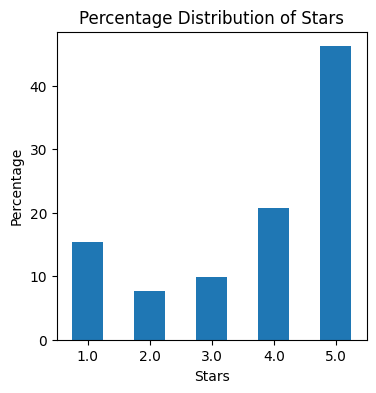

In [ ]:
# Calculate percentage distribution of star ratings
total_reviews = len(train_data)
ratings_count = train_data['stars'].value_counts()
percentage_distribution = (ratings_count / total_reviews) * 100

# Visualize the distribution using a bar plot
plt.figure(figsize=(4, 4))
percentage_distribution.sort_index().plot(kind='bar')
plt.title('Percentage Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

Clearly, the data is not uniformly distributed. The 5-star ratings vastly outnumber other ratings, a machine learning model might become overly inclined to predict 5 stars for most cases, leading to an imbalanced prediction output.

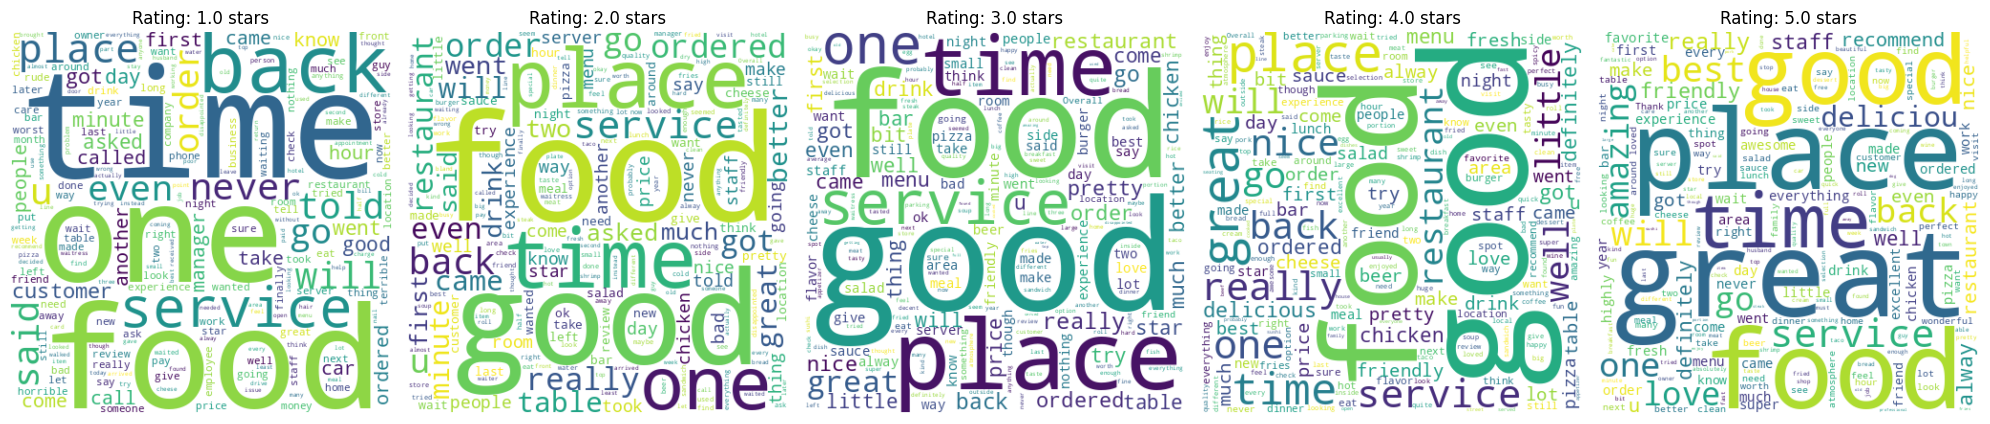

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a figure and axis to hold subplots
fig, axs = plt.subplots(1, len(train_data['stars'].unique()), figsize=(20, 5))

# Iterate through each unique rating
for i, rating in enumerate(sorted(train_data['stars'].unique())):
    # Create a single line of text to feed it to WordCloud
    text = ' '.join(review for review in train_data[train_data['stars'] == rating]['text'].values)

    # Generate the WordCloud for the current rating
    wordcloud = WordCloud(collocations=False, background_color='white', width=400, height=400).generate(text)

    # Plot the WordCloud in the respective subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'Rating: {rating} stars')
    axs[i].axis('off')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()


# 1. Data pre-processing:
Pre-process the data by removing the punctuation and stopwords and converting all words to lowercase. Moreover, converting the stars into three levels: Positive > 3, negative <= 2, and neutral = 3.

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(filtered_tokens)

# Preprocess the 'text' column in the train dataset
train_data['text'] = train_data['text'].apply(preprocess_text)

# Convert stars into three levels: Positive > 3, negative <= 2, and neutral = 3
train_data['sentiment'] = train_data['stars'].apply(lambda x: 'positive' if x > 3 else ('negative' if x <= 2 else 'neutral'))

# Display the preprocessed data
print(train_data.head())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
                                                text  stars sentiment
0  went lunch found burger meh obvious focus burg...    2.0  negative
1  needed new tires wifes car special order next ...    5.0  positive
2  jim woltman works goleta honda 5 stars knowled...    5.0  positive
3  times get shrimp theyve got nice selection dif...    4.0  positive
4  one fantastic place eat whether hungry need go...    5.0  positive


In [ ]:
# Preprocess the 'text' column in the test dataset
test_data['text'] = test_data['text'].apply(preprocess_text)

# Convert stars into three levels: Positive > 3, negative <= 2, and neutral = 3
test_data['sentiment'] = test_data['stars'].apply(lambda x: 'positive' if x > 3 else ('negative' if x <= 2 else 'neutral'))

# Display the preprocessed data
print(test_data.head())

                                                text  stars sentiment
0  hidden treasure awesome service delicious food...    5.0  positive
1  family patients since 5 years old 34 trust qua...    5.0  positive
2  rarely get pedicures blue nails practice combi...    5.0  positive
3  came large group may items missing menu lobste...    2.0  negative
4  view great morgans pier bartenders even good s...    2.0  negative


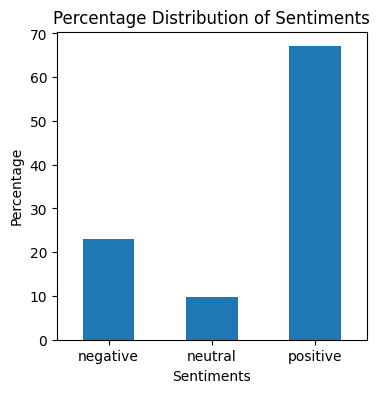

In [ ]:
# Calculate percentage distribution of star ratings
total_reviews = len(train_data)
ratings_count = train_data['sentiment'].value_counts()
percentage_distribution = (ratings_count / total_reviews) * 100

# Visualize the distribution using a bar plot
plt.figure(figsize=(4, 4))
percentage_distribution.sort_index().plot(kind='bar')
plt.title('Percentage Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()

After preprocessing, the data is now more non-uniformly distributed. The positive reviews vastly outnumber negative and neutral reviews, so any regular model will be biased towards positive reviews.

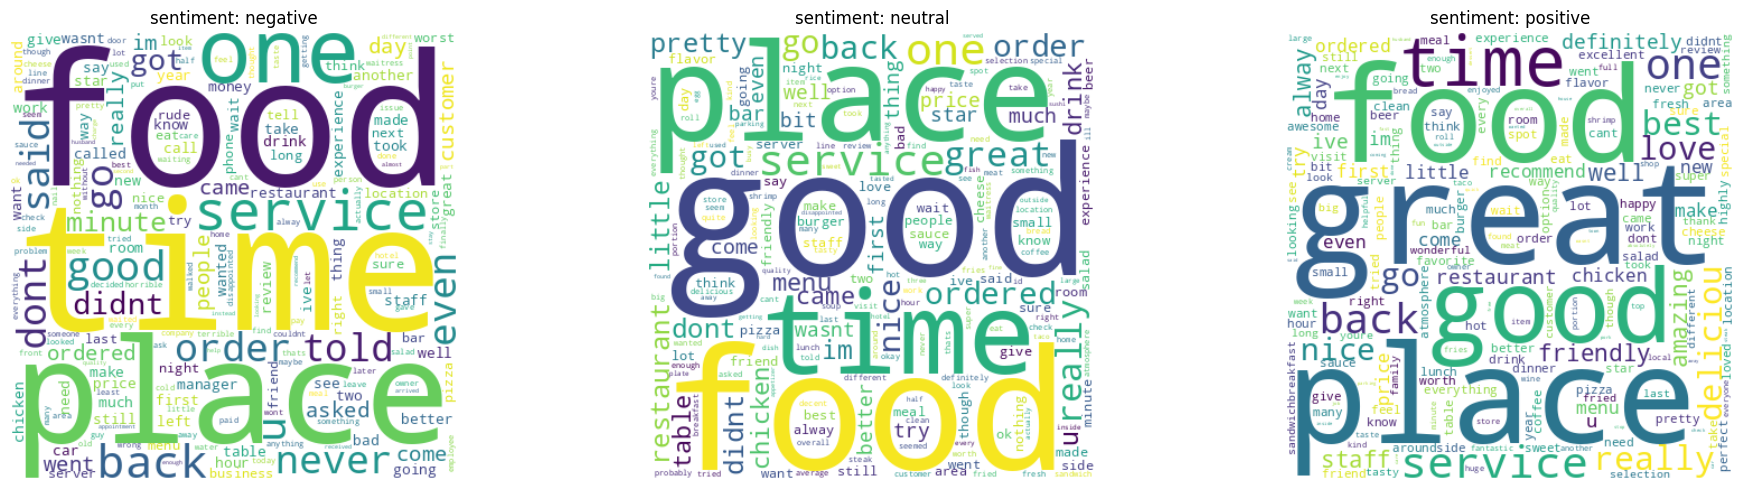

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create a figure and axis to hold subplots
fig, axs = plt.subplots(1, len(train_data['sentiment'].unique()), figsize=(20, 5))

# Iterate through each unique rating
for i, rating in enumerate(sorted(train_data['sentiment'].unique())):
    # Create a single line of text to feed it to WordCloud
    text = ' '.join(review for review in train_data[train_data['sentiment'] == rating]['text'].values)

    # Generate the WordCloud for the current rating
    wordcloud = WordCloud(collocations=False, background_color='white', width=400, height=400).generate(text)

    # Plot the WordCloud in the respective subplot
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(f'sentiment: {rating}')
    axs[i].axis('off')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()


# 2. Input data preparation:
The input of the Transformer model is a fixedlength review sequence where integer numbers represent words. In this part, you need to build vocabulary for the dataset and pad the review data to a fixed length.

The maximum length of any sentence is: 528 tokens


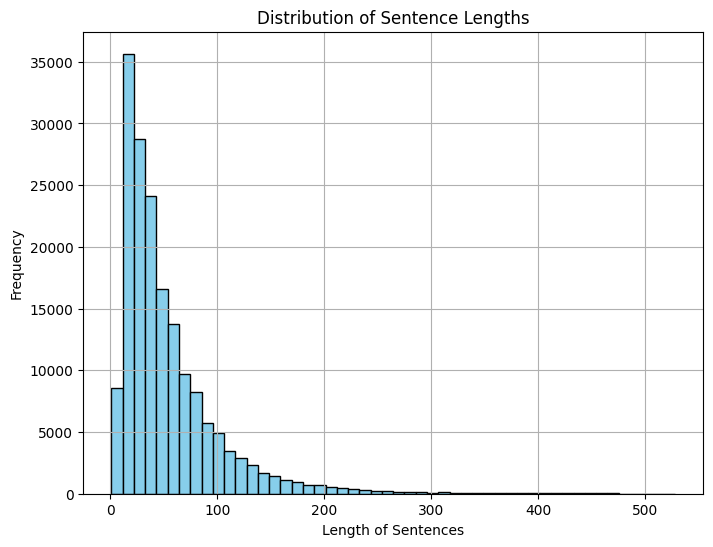

In [ ]:
# Tokenize the sentences
tokenized_sentences = train_data['text'].apply(nltk.word_tokenize)

# Calculate the lengths of sentences
sentence_lengths = [len(sentence) for sentence in tokenized_sentences]

# Get the maximum length of any sentence
max_sentence_length = max(sentence_lengths)

print(f"The maximum length of any sentence is: {max_sentence_length} tokens")

# Create a histogram to visualize the distribution of sentence lengths
plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length of Sentences')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Most of the preprocessed reviews now have length less than 100.

In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit tokenizer on the preprocessed review data
tokenizer.fit_on_texts(train_data['text'])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(train_data['text'])

# Define the maximum length for padding sequences
max_length = 100

# Pad sequences to a fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Vocabulary size (adding 1 for the padding token)
vocab_size = len(tokenizer.word_index) + 1

# Display the vocabulary size and padded sequences
print(f'Vocabulary size: {vocab_size}')
print(f'Padded sequences shape: {padded_sequences.shape}')


Vocabulary size: 148275
Padded sequences shape: (174757, 100)


In [ ]:
# Assign the entire training dataset to a new variable
train_data_x = train_data

# Assign the entire testing dataset to a new variable
test_data_x = test_data

# Extract only the 'text' column from the training dataset
X_train = train_data_x['text']

# Extract only the 'sentiment' column from the training dataset
y_train = train_data_x['sentiment']

# Extract only the 'text' column from the testing dataset
X_test = test_data_x['text']

# Extract only the 'sentiment' column from the testing dataset
y_test = test_data_x['sentiment']

# Convert the text data in the training set into sequences using the tokenizer
X_train = tokenizer.texts_to_sequences(X_train)

# Convert the text data in the testing set into sequences using the tokenizer
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences in the training set to ensure uniform length (300) for neural network input
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=300)

# Pad sequences in the testing set to ensure uniform length (300) for neural network input
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=300)

In [ ]:
# Define mapping for categorical labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# Convert categorical labels to numerical using mapping
y_train_numeric = y_train.map(label_map)

# Convert numerical labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_numeric, num_classes=3)  # 3 classes: negative, neutral, positive

# Convert categorical labels to numerical using mapping for y_test
y_test_numeric = y_test.map(label_map)

# Convert numerical labels to one-hot encoded format for y_test
y_test_encoded = to_categorical(y_test_numeric, num_classes=3)  # 3 classes: negative, neutral, positive

# EXPERMIENT 1: Convolutional Neural Networks (CNN)
Build model and add layers:

Embedding layer: represent words by dense vectors where a vector represents the projection of the word into a continuous vector space.

Dropout: regularize the model to avoid overfitting by excluding 50% of the neurons from activation and weight updates while training.

Conv1D: the core building block of a CNN, and the layer where the majority of computation occurs. It creates a filter that calculates a higher-lever representation of the data, feeding the next layers with chunks instead of words.

MaxPooling1D: extract higher-level representation of the data, indicating more information will be expressed by max pooling.

LSTM: learn sequences of data in the context.

Dense: represents the dimension of final output.

In [ ]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128, input_length=300),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          2560000   
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 74, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

In [ ]:
print(X_train.shape)
print(y_train_encoded.shape)

(174757, 300)
(174757, 3)


In [ ]:
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(X_train, y_train_encoded, epochs=10, validation_split=0.3, batch_size=100, shuffle=True, callbacks=[variable_learning_rate, cnn_model_checkpoint])


Epoch 1/10
1224/1224 [==============================] - 140s 101ms/step - loss: 0.6544 - accuracy: 0.7500 - val_loss: 0.3935 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 2/10
1224/1224 [==============================] - 42s 34ms/step - loss: 0.3439 - accuracy: 0.8686 - val_loss: 0.3411 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 3/10
1224/1224 [==============================] - 24s 20ms/step - loss: 0.2798 - accuracy: 0.8924 - val_loss: 0.3446 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/10
1224/1224 [==============================] - 21s 18ms/step - loss: 0.2354 - accuracy: 0.9098 - val_loss: 0.3872 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 5/10
1224/1224 [==============================] - 21s 17ms/step - loss: 0.1750 - accuracy: 0.9352 - val_loss: 0.4106 - val_accuracy: 0.8707 - lr: 1.0000e-04
Epoch 6/10
1224/1224 [==============================] - 19s 15ms/step - loss: 0.1659 - accuracy: 0.9389 - val_loss: 0.4271 - val_accuracy: 0.8701 - lr: 1.0000e-04
Epoch 7/10
1224/1224 [==============

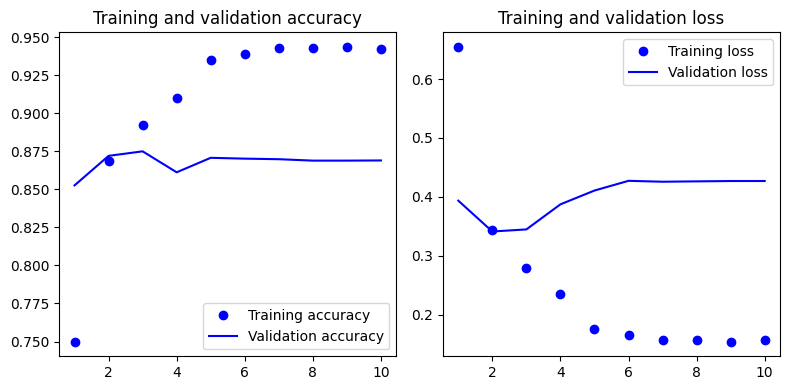

5462/5462 [==============================] - 20s 4ms/step - loss: 0.2184 - accuracy: 0.9289
Train accuracy: 0.929
5462/5462 [==============================] - 15s 3ms/step
Train precision: 0.925
Train recall: 0.929
Train F1 score: 0.927
437/437 [==============================] - 2s 4ms/step - loss: 0.4273 - accuracy: 0.8699
Test accuracy: 0.870
437/437 [==============================] - 1s 3ms/step
Test precision: 0.859
Test recall: 0.870
Test F1 score: 0.863


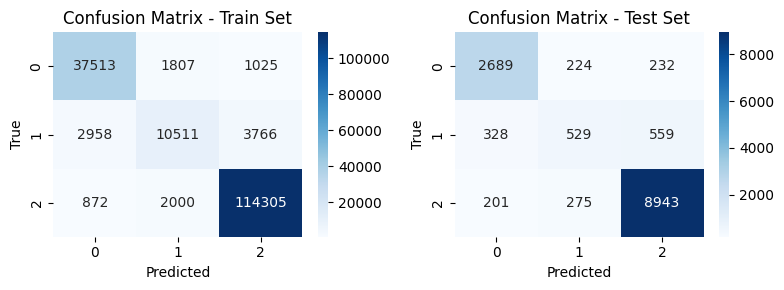

Classification Report - Train Set
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     40345
           1       0.73      0.61      0.67     17235
           2       0.96      0.98      0.97    117177

    accuracy                           0.93    174757
   macro avg       0.87      0.84      0.85    174757
weighted avg       0.93      0.93      0.93    174757

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3145
           1       0.51      0.37      0.43      1416
           2       0.92      0.95      0.93      9419

    accuracy                           0.87     13980
   macro avg       0.76      0.73      0.74     13980
weighted avg       0.86      0.87      0.86     13980



In [ ]:
plot_and_print(history_cnn, model_cnn, X_train, y_train_encoded, X_test, y_test_encoded)

# EXPERIMENT 2: Recurrent Neural Networks (RNN)
Build model and add layers
Embedding layer: represent words by dense vectors where a vector represents the projection of the word into a continuous vector space.

Bidirectional layers: enable straight (past) and reverse (future) traversal of input words so that LSTM can use context when predicting the next sample.

Dense: change the dimension of the preceding bidirectional layer so that the model can define the relationship between the values of the data.

Dropout: regularize the model by excluding 50% of the neurons from activation and weight updates while training a network. The purpose is to reduce overfitting and improve model performance.

Dense: dimension is set to 3 as we have 3 classes.

The rest of the workflow is similar with that of CNN.

In [ ]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         49664     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

In [ ]:
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train, y_train_encoded, epochs=10, validation_split=0.3, batch_size=100, shuffle=True, callbacks=[variable_learning_rate, rnn_model_checkpoint])


Epoch 1/10
1224/1224 [==============================] - 195s 154ms/step - loss: 0.4525 - accuracy: 0.8346 - val_loss: 0.3533 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 2/10
1224/1224 [==============================] - 78s 64ms/step - loss: 0.3229 - accuracy: 0.8784 - val_loss: 0.3562 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 3/10
1224/1224 [==============================] - 62s 51ms/step - loss: 0.2805 - accuracy: 0.8941 - val_loss: 0.3779 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 4/10
1224/1224 [==============================] - 62s 51ms/step - loss: 0.2189 - accuracy: 0.9166 - val_loss: 0.4172 - val_accuracy: 0.8640 - lr: 1.0000e-04
Epoch 5/10
1224/1224 [==============================] - 60s 49ms/step - loss: 0.2041 - accuracy: 0.9234 - val_loss: 0.4299 - val_accuracy: 0.8612 - lr: 1.0000e-04
Epoch 6/10
1224/1224 [==============================] - 57s 47ms/step - loss: 0.1901 - accuracy: 0.9292 - val_loss: 0.4391 - val_accuracy: 0.8616 - lr: 1.0000e-05
Epoch 7/10
1224/1224 [==========

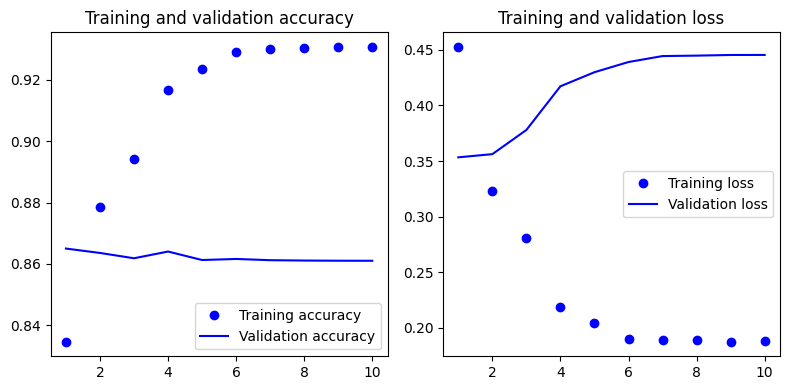

5462/5462 [==============================] - 88s 16ms/step - loss: 0.2598 - accuracy: 0.9104
Train accuracy: 0.910
5462/5462 [==============================] - 85s 15ms/step
Train precision: 0.907
Train recall: 0.910
Train F1 score: 0.908
437/437 [==============================] - 7s 17ms/step - loss: 0.4374 - accuracy: 0.8646
Test accuracy: 0.865
437/437 [==============================] - 7s 15ms/step
Test precision: 0.857
Test recall: 0.865
Test F1 score: 0.860


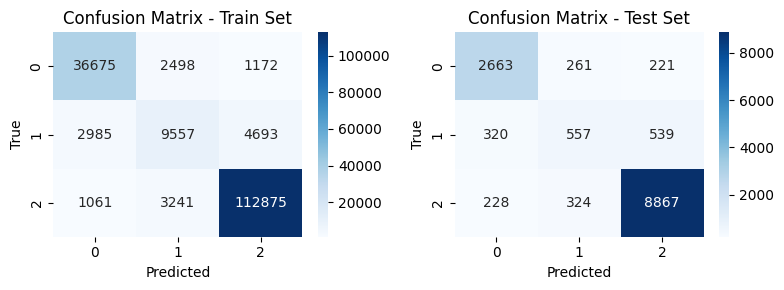

Classification Report - Train Set
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     40345
           1       0.62      0.55      0.59     17235
           2       0.95      0.96      0.96    117177

    accuracy                           0.91    174757
   macro avg       0.83      0.81      0.82    174757
weighted avg       0.91      0.91      0.91    174757

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3145
           1       0.49      0.39      0.44      1416
           2       0.92      0.94      0.93      9419

    accuracy                           0.86     13980
   macro avg       0.75      0.73      0.73     13980
weighted avg       0.86      0.86      0.86     13980



In [ ]:
plot_and_print(history_rnn, model_rnn, X_train, y_train_encoded, X_test, y_test_encoded)

# EXPERMIENT 3: Transformer from scratch

In [ ]:
import pandas as pd
import nltk
import re

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Load the CSV files
train_df = pd.read_csv('/kaggle/input/csce633-yelp/yelp_review_train.csv')
test_df = pd.read_csv('/kaggle/input/csce633-yelp/yelp_review_test.csv')

stop_words = set(stopwords.words('english'))
# Define function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing function to reviews
train_df['preprocessed_review'] = train_df['text'].apply(preprocess_text)
test_df['preprocessed_review'] = test_df['text'].apply(preprocess_text)

# Convert star ratings into three levels
def convert_rating(rating):
    if rating > 3:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

train_df['sentiment'] = train_df['stars'].apply(convert_rating)
test_df['sentiment'] = test_df['stars'].apply(convert_rating)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Example of the preprocessed data
train_df[['text', 'preprocessed_review', 'stars', 'sentiment']].head(5)

,text,preprocessed_review,stars,sentiment
0,Went for lunch and found that my burger was me...,went lunch found burger meh obvious focus burg...,2.0,negative
1,I needed a new tires for my wife's car. They h...,needed new tires wifes car special order next ...,5.0,positive
2,Jim Woltman who works at Goleta Honda is 5 sta...,jim woltman works goleta honda 5 stars knowled...,5.0,positive
3,Been here a few times to get some shrimp. The...,times get shrimp theyve got nice selection dif...,4.0,positive
4,This is one fantastic place to eat whether you...,one fantastic place eat whether hungry need go...,5.0,positive


In [ ]:
test_df[['text', 'preprocessed_review', 'stars', 'sentiment']].head(5)

,text,preprocessed_review,stars,sentiment
0,"Hidden treasure! Awesome service, delicious fo...",hidden treasure awesome service delicious food...,5.0,positive
1,My family and I have been patients since I wa...,family patients since 5 years old 34 trust qua...,5.0,positive
2,"I rarely get pedicures, but Blue Nail's practi...",rarely get pedicures blue nails practice combi...,5.0,positive
3,"We came with a large group, may of the items w...",came large group may items missing menu lobste...,2.0,negative
4,The view is great from Morgan's Pier. The bart...,view great morgans pier bartenders even good s...,2.0,negative


In [ ]:
from torchtext.vocab import Vocab
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import Counter

# Tokenize reviews to build the vocabulary
tokenized_reviews = train_df['preprocessed_review'].apply(lambda x: x.split())
all_tokens = [token for sublist in tokenized_reviews for token in sublist]

# Create a Counter of tokens and sort by frequency
token_counter = Counter(all_tokens)
sorted_token_counter = sorted(token_counter.items(), key=lambda item: item[1], reverse=True)

# Create vocabulary mapping words to indices
vocab = {"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3}  # Special tokens
index = len(vocab)
for token, freq in sorted_token_counter:
    if token not in vocab:
        vocab[token] = index
        index += 1

# Map words to indices and pad sequences
def preprocess_and_pad(text):
    tokens = text.split()
    indexed_tokens = [vocab.get(token, vocab['<unk>']) for token in tokens]
    return indexed_tokens

# Apply padding to sequences
max_seq_length = 100  # Set your desired sequence length
train_df['padded_review'] = train_df['preprocessed_review'].apply(preprocess_and_pad)
test_df['padded_review'] = test_df['preprocessed_review'].apply(preprocess_and_pad)

# Pad sequences to a fixed length
def pad_sequence_to_length(sequence):
    if len(sequence) < max_seq_length:
        padded_sequence = sequence + [vocab['<pad>']] * (max_seq_length - len(sequence))
        return padded_sequence[:max_seq_length]  # Truncate if longer than max_seq_length
    else:
        return sequence[:max_seq_length]

train_df['padded_review'] = train_df['padded_review'].apply(pad_sequence_to_length)
test_df['padded_review'] = test_df['padded_review'].apply(pad_sequence_to_length)

# Convert the padded sequences to PyTorch tensors
train_sequences = [torch.tensor(seq) for seq in train_df['padded_review']]
test_sequences = [torch.tensor(seq) for seq in test_df['padded_review']]

# Pad sequences in the batch to create a tensor
padded_train_sequences = pad_sequence(train_sequences, batch_first=True)
padded_test_sequences = pad_sequence(test_sequences, batch_first=True)

# Example of the prepared input data
print("Padded Train Sequences Shape:", padded_train_sequences.shape)
print("Padded Test Sequences Shape:", padded_test_sequences.shape)


Padded Train Sequences Shape: torch.Size([174757, 100])
Padded Test Sequences Shape: torch.Size([13980, 100])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Positional Encoding module for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=100):
        super(PositionalEncoding, self).__init__()
        # Creating positional encoding matrix
        self.encoding = torch.zeros(max_seq_len, d_model)
        # Creating positions ranging from 0 to max_seq_len and converting to float
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        # Generating the div_term used in sinusoidal positional embeddings
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        # Calculating sinusoidal positional embeddings: even indices - sine; odd indices - cosine
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Adding a batch dimension

    def forward(self, x):
        # Applying positional encoding to input by adding it to the input tensor
        return x + self.encoding[:, :x.size(1)].to(x.device)  # Truncate positional encoding to match input sequence length

# Multi-Head Attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Initializing multi-head attention mechanism
        self.d_model = d_model
        self.num_heads = num_heads
        # Linear transformations for queries, keys, and values
        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.final_linear = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        # Splitting input into multiple heads for parallel processing
        x = x.view(batch_size, -1, self.num_heads, self.d_model // self.num_heads)
        return x.permute(0, 2, 1, 3)

    def forward(self, query, key, value, mask=None):
        # Performing multi-head attention operation
        batch_size = query.size(0)
        query = self.split_heads(self.query_linear(query), batch_size)
        key = self.split_heads(self.key_linear(key), batch_size)
        value = self.split_heads(self.value_linear(value), batch_size)

        # Calculating attention scores
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))

        # Masking scores if a mask is provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Applying softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, value)
        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.final_linear(output)

# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(TransformerEncoderLayer, self).__init__()
        # Initializing transformer encoder layer
        self.multihead_attention = MultiHeadAttention(d_model, num_heads)
        # Feed-forward neural network for the encoder layer
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 2048),  # Linear transformation to 2048 neurons
            nn.ReLU(),  # Applying ReLU activation function
            nn.Linear(2048, d_model)  # Linear transformation back to d_model neurons
        )
        self.layer_norm1 = nn.LayerNorm(d_model)  # Layer normalization
        self.layer_norm2 = nn.LayerNorm(d_model)  # Layer normalization
        self.dropout = nn.Dropout(0.1)  # Dropout regularization

    def forward(self, x, mask=None):
        # Forward pass through the encoder layer
        att_output = self.multihead_attention(x, x, x, mask)  # Multi-head self-attention
        att_output = self.dropout(att_output)  # Applying dropout regularization
        att_output = self.layer_norm1(x + att_output)  # Residual connection and normalization

        ff_output = self.feed_forward(att_output)  # Passing through feed-forward neural network
        ff_output = self.dropout(ff_output)  # Applying dropout regularization
        output = self.layer_norm2(att_output + ff_output)  # Residual connection and normalization
        return output  # Returning the output of the encoder layer

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, max_seq_len, num_attention_layers):
        super(TransformerEncoder, self).__init__()
        # Initializing transformer encoder
        self.embedding = nn.Embedding(vocab_size, d_model)  # Embedding layer for token embeddings
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)  # Positional encoding for sequence information
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads) for _ in range(num_attention_layers)])  # Stack of transformer encoder layers

    def forward(self, x, mask=None):
        # Forward pass through the transformer encoder
        embedded = self.embedding(x)  # Getting token embeddings for the input sequence
        embedded *= self.embedding.embedding_dim ** 0.5  # Scaling the embeddings by square root of dimensionality
        embedded = self.positional_encoding(embedded)  # Applying positional encoding to the embeddings

        for layer in self.encoder_layers:  # Loop through the encoder layers
            embedded = layer(embedded, mask)  # Pass the embeddings through each encoder layer

        return embedded  # Return the output of the transformer encoder


# Transformer-based Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_encoder, num_classes):
        super(TransformerClassifier, self).__init__()
        # Initializing transformer-based classifier
        self.transformer = transformer_encoder  # Reference to the transformer encoder
        self.fc = nn.Linear(self.transformer.embedding.embedding_dim, num_classes)  # Fully connected layer for classification

    def forward(self, x, mask=None):
        # Forward pass through the classifier
        encoder_output = self.transformer(x, mask)  # Get the output from the transformer encoder
        # Pooling operation across time steps
        pooled = F.avg_pool1d(encoder_output.permute(0, 2, 1), encoder_output.size(1)).squeeze(-1)
        return self.fc(pooled)  # Return the output after passing through the fully connected layer



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

# Convert labels to numerical values
label_dict = {'positive': 2, 'neutral': 1, 'negative': 0}
train_df['label'] = train_df['sentiment'].map(label_dict)
test_df['label'] = test_df['sentiment'].map(label_dict)

# Prepare input and labels for the model
X = padded_train_sequences  # Padded sequences from previous steps
y = train_df['label'].values

# Splitting the dataset into train and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=42)

# Create TensorDatasets
train_data = TensorDataset(train_X, torch.tensor(train_y))
val_data = TensorDataset(val_X, torch.tensor(val_y))
test_data = TensorDataset(padded_test_sequences, torch.tensor(test_df['label']))

# Set up DataLoader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


Experiment with number of attention layers and hidden layer dimensions.

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.cuda.amp import autocast, GradScaler  # Import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Training loop
def function_training(vocab_size, d_model, num_heads, max_seq_len, num_attention_layers, num):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    train_accuracies = []  # List to store training accuracies
    val_accuracies = []  # List to store validation accuracies
    transformer_encoder = TransformerEncoder(vocab_size, d_model, num_heads, max_seq_len, num_attention_layers)  # Initialize transformer encoder
    epochs = 10  # Number of training epochs
    best_accuracy = 0.0  # Initialize best accuracy

    # Define model, loss function, optimizer
    model = TransformerClassifier(transformer_encoder, num_classes=3)  # Initialize the classifier model

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose the device for training
    model.to(device)  # Move model to the selected device
    criterion = nn.CrossEntropyLoss().to(device)  # Define the loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)  # Define the optimizer
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True, min_lr=0.0000001)

    scaler = GradScaler()  # For mixed precision training

    for epoch in range(epochs):  # Training loop
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Initialize running loss
        total = 0  # Initialize total count of samples
        correct = 0  # Initialize count of correctly predicted samples
        for batch_idx, (inputs, labels) in enumerate(train_loader):  # Iterate over training data
            optimizer.zero_grad()  # Zero gradients
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            with autocast():  # Automatic mixed precision training context
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
            scaler.scale(loss).backward()  # Backpropagation with scaled gradients
            scaler.step(optimizer)  # Update optimizer parameters
            scaler.update()  # Updates the scale for next iteration

            running_loss += loss.item()  # Accumulate running loss
            _, predicted = torch.max(outputs, 1)  # Get predictions
            total += labels.size(0)  # Increment total count
            correct += (predicted == labels).sum().item()  # Count correct predictions

        train_loss = running_loss / len(train_loader)  # Calculate average training loss
        train_accuracy = 100 * correct / total  # Calculate training accuracy
        train_losses.append(train_loss)  # Append training loss to list
        train_accuracies.append(train_accuracy)  # Append training accuracy to list

        # Validation
        model.eval()  # Set the model to evaluation mode
        correct_val = 0  # Initialize count of correctly predicted validation samples
        total_val = 0  # Initialize total count of validation samples
        val_loss = 0.0  # Initialize validation loss

        with torch.no_grad():  # Disable gradient calculation in validation
            for inputs, labels in val_loader:  # Iterate over validation data
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
                _, predicted = torch.max(outputs, 1)  # Get predictions
                total_val += labels.size(0)  # Increment total count
                correct_val += (predicted == labels).sum().item()  # Count correct predictions

        val_loss /= len(val_loader.dataset)  # Calculate average validation loss
        val_accuracy = 100 * correct_val / total_val  # Calculate validation accuracy
        val_losses.append(val_loss)  # Append validation loss to list
        val_accuracies.append(val_accuracy)  # Append validation accuracy to list

        # Print epoch-wise metrics
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.5f}, Train Acc: {train_accuracy:.3f}%, "
              f"Val Loss: {val_loss:.5f}, Val Acc: {val_accuracy:.3f}% "
              f"Learning Rate: {optimizer.param_groups[0]['lr']:.8f}"
        )

        scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        # Save the model with the best validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model_{num}.pt')  # Save model's state_dict

    # Plotting training curve (training accuracy)
    fig, axes = plt.subplots(2, 1, figsize=(4, 4))

    # Plotting Accuracies
    axes[0].plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    axes[0].plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    # Plotting Losses
    axes[1].plot(range(1, epochs + 1), train_losses, label='Train Loss')
    axes[1].plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()  # Adjusts subplot parameters to fit into the figure area
    plt.show()

    best_model = TransformerClassifier(transformer_encoder, num_classes=3)  # Initialize best model
    best_model.load_state_dict(torch.load(f'best_model_{num}.pt'))  # Load the saved weights
    best_model.to(device)  # Move best model to GPU if available

    # Set the best model to evaluation mode
    best_model.eval()

    # Evaluate the best model on the test set
    correct_test = 0  # Initialize count of correctly predicted test samples
    total_test = 0  # Initialize total count of test samples

    with torch.no_grad():  # Disable gradient calculation in test evaluation
        for inputs, labels in test_loader:  # Iterate over test data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = best_model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions
            total_test += labels.size(0)  # Increment total count
            correct_test += (predicted == labels).sum().item()  # Count correct predictions

    test_accuracy = 100 * correct_test / total_test  # Calculate test accuracy

    print(f"Accuracy of the model on the test set: {test_accuracy:.3f}%")  # Display test accuracy



In [ ]:
# this list represents our hyperparameters: [hidden dimension, number of attention heads, number of attention layers]
exp = [[128, 4, 4], [128, 8, 8], [64, 4, 4], [64, 8, 8], [256, 8, 8], [512, 8, 8], [512, 8, 4], [512, 4, 8], [512, 16, 16], [1024, 16, 16]]
vocab_size = len(vocab)
max_seq_len = 100  # Maximum sequence length


#### Transformer 1:
* Hidden dimension: 128
* Number of attention heads: 4
* Number of attention layers: 4


Epoch [1/10], Train Loss: 0.76233, Train Acc: 69.126%, Val Loss: 0.69567, Val Acc: 72.723% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.64459, Train Acc: 75.009%, Val Loss: 0.60625, Val Acc: 76.545% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.58658, Train Acc: 77.426%, Val Loss: 0.58189, Val Acc: 77.535% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.55872, Train Acc: 78.549%, Val Loss: 0.75138, Val Acc: 69.289% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.53923, Train Acc: 79.418%, Val Loss: 0.59628, Val Acc: 76.373% Learning Rate: 0.00100000
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch [6/10], Train Loss: 0.51797, Train Acc: 80.239%, Val Loss: 0.53771, Val Acc: 79.423% Learning Rate: 0.00010000
Epoch [7/10], Train Loss: 0.51462, Train Acc: 80.392%, Val Loss: 0.53306, Val Acc: 79.618% Learning Rate: 0.00010000
Epoch [8/10], Train Loss: 0.51220, Train Acc: 80.469%, Val Loss: 0.53099, Val Acc: 79.744% Learning Rate: 0.00010000
Ep

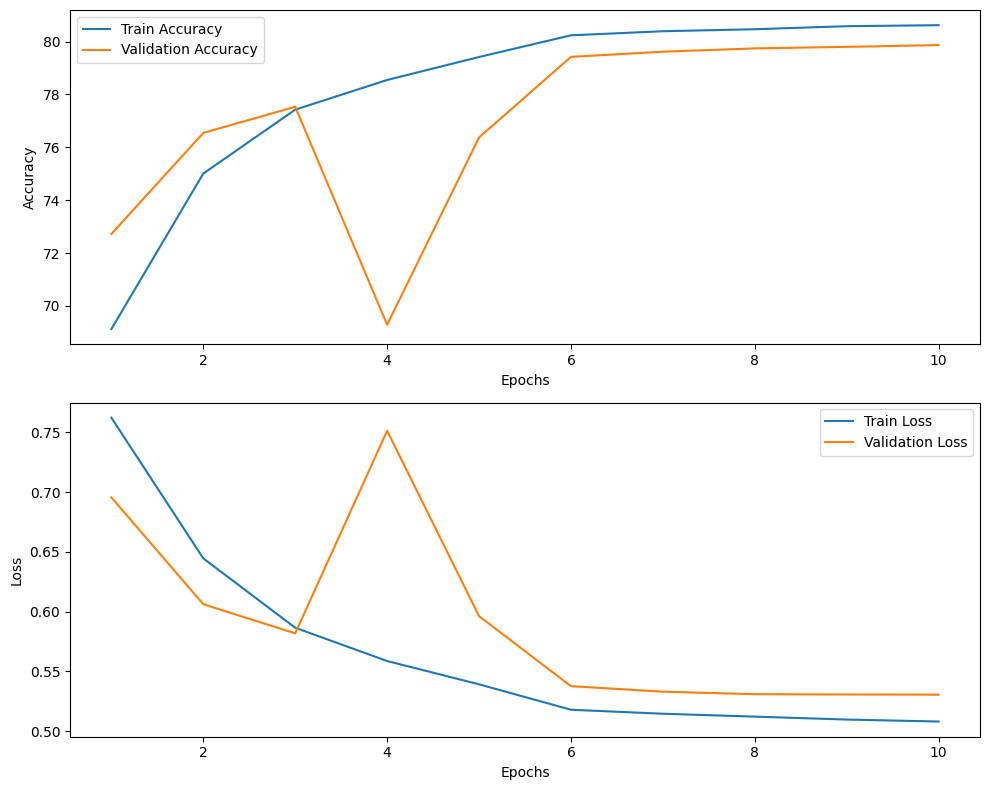

Accuracy of the model on the test set: 79.549%


In [ ]:
function_training(vocab_size, exp[0][0], exp[0][1], max_seq_len, exp[0][2], 1)


#### Transformer 2:
* Hidden dimension: 128
* Number of attention heads: 8
* Number of attention layers: 8


Epoch [1/10], Train Loss: 0.72588, Train Acc: 70.996%, Val Loss: 0.64877, Val Acc: 74.039% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.59751, Train Acc: 76.831%, Val Loss: 1.31315, Val Acc: 45.914% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.55396, Train Acc: 78.687%, Val Loss: 0.70932, Val Acc: 71.149% Learning Rate: 0.00100000
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
Epoch [4/10], Train Loss: 0.52013, Train Acc: 80.113%, Val Loss: 0.52090, Val Acc: 79.875% Learning Rate: 0.00010000
Epoch [5/10], Train Loss: 0.51484, Train Acc: 80.223%, Val Loss: 0.52120, Val Acc: 79.807% Learning Rate: 0.00010000
Epoch [6/10], Train Loss: 0.51113, Train Acc: 80.375%, Val Loss: 0.51398, Val Acc: 80.110% Learning Rate: 0.00010000
Epoch [7/10], Train Loss: 0.50786, Train Acc: 80.497%, Val Loss: 0.51160, Val Acc: 80.184% Learning Rate: 0.00010000
Epoch [8/10], Train Loss: 0.50482, Train Acc: 80.630%, Val Loss: 0.50894, Val Acc: 80.253% Learning Rate: 0.00010000
Ep

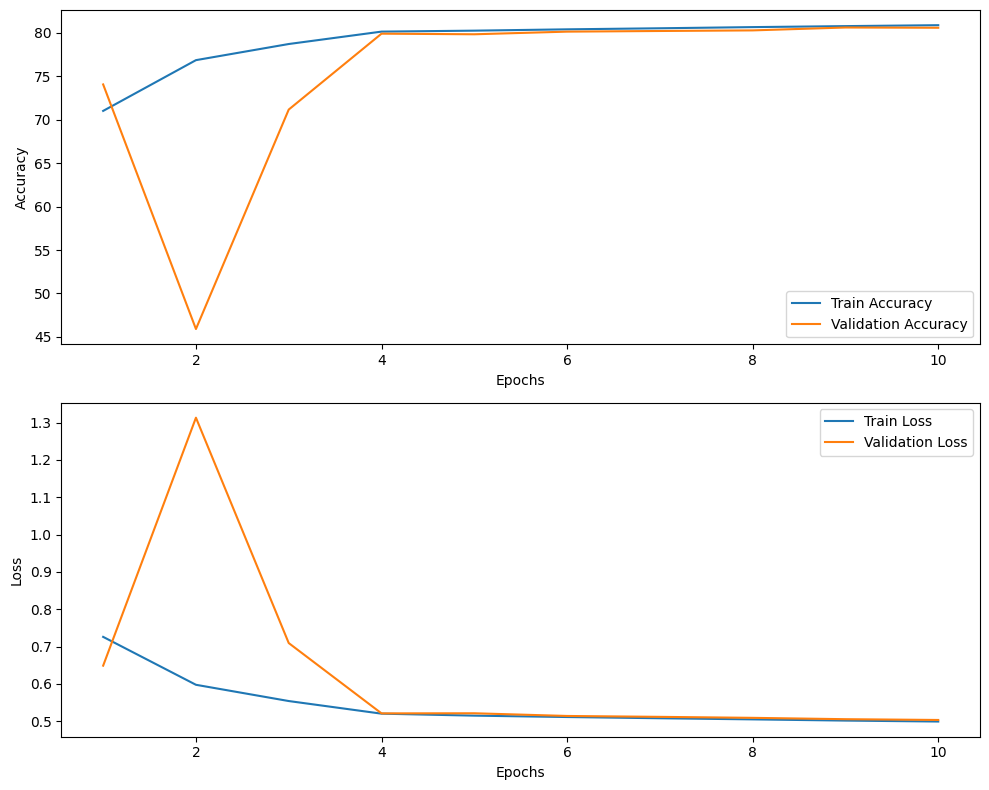

Accuracy of the model on the test set: 80.694%


In [ ]:
function_training(vocab_size, exp[1][0], exp[1][1], max_seq_len, exp[1][2], 2)

#### Transformer 3:
* Hidden dimension: 64
* Number of attention heads: 4
* Number of attention layers: 4


Epoch [1/10], Train Loss: 0.76961, Train Acc: 68.320%, Val Loss: 0.73184, Val Acc: 70.611% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.68410, Train Acc: 73.214%, Val Loss: 0.65949, Val Acc: 74.548% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.64541, Train Acc: 75.212%, Val Loss: 0.63761, Val Acc: 75.549% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.62381, Train Acc: 76.120%, Val Loss: 0.61485, Val Acc: 76.528% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.60346, Train Acc: 76.962%, Val Loss: 0.59501, Val Acc: 77.163% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.58495, Train Acc: 77.756%, Val Loss: 0.60003, Val Acc: 77.083% Learning Rate: 0.00100000
Epoch [7/10], Train Loss: 0.56951, Train Acc: 78.353%, Val Loss: 0.56443, Val Acc: 78.313% Learning Rate: 0.00100000
Epoch [8/10], Train Loss: 0.55481, Train Acc: 78.930%, Val Loss: 0.55643, Val Acc: 78.811% Learning Rate: 0.00100000
Epoch [9/10], Train Loss: 0.54022, Train Acc: 79.483%, Val Loss:

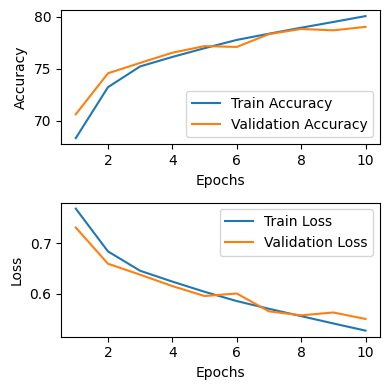

Accuracy of the model on the test set: 79.521%


In [ ]:
function_training(vocab_size, exp[2][0], exp[2][1], max_seq_len, exp[2][2], 3)

#### Transformer 4:
* Hidden dimension: 64
* Number of attention heads: 8
* Number of attention layers: 8


Epoch [1/10], Train Loss: 0.72281, Train Acc: 70.925%, Val Loss: 0.67144, Val Acc: 73.787% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.60329, Train Acc: 76.672%, Val Loss: 0.58000, Val Acc: 77.735% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.56119, Train Acc: 78.434%, Val Loss: 0.56032, Val Acc: 78.227% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.53841, Train Acc: 79.348%, Val Loss: 0.52687, Val Acc: 79.578% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.52173, Train Acc: 79.952%, Val Loss: 0.51293, Val Acc: 80.087% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.50734, Train Acc: 80.577%, Val Loss: 0.51496, Val Acc: 80.001% Learning Rate: 0.00100000
Epoch [7/10], Train Loss: 0.49564, Train Acc: 81.017%, Val Loss: 0.53543, Val Acc: 79.486% Learning Rate: 0.00100000
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch [8/10], Train Loss: 0.47938, Train Acc: 81.696%, Val Loss: 0.48661, Val Acc: 81.186% Learning Rate: 0.00010000
Ep

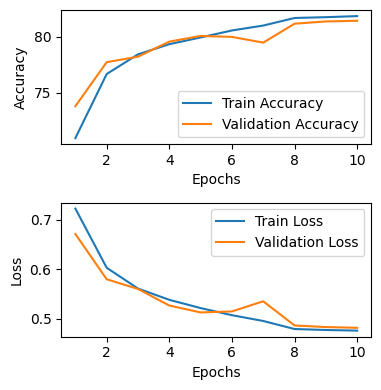

Accuracy of the model on the test set: 81.352%


In [ ]:
function_training(vocab_size, exp[3][0], exp[3][1], max_seq_len, exp[3][2], 4)

#### Transformer 5:
* Hidden dimension: 256
* Number of attention heads: 8
* Number of attention layers: 8


Epoch [1/10], Train Loss: 0.65614, Train Acc: 74.169%, Val Loss: 0.64681, Val Acc: 75.463% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.54073, Train Acc: 79.308%, Val Loss: 0.51912, Val Acc: 80.018% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.49940, Train Acc: 80.865%, Val Loss: 0.49722, Val Acc: 80.882% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.47302, Train Acc: 81.918%, Val Loss: 0.57566, Val Acc: 77.729% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.45703, Train Acc: 82.623%, Val Loss: 0.46615, Val Acc: 82.158% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.44195, Train Acc: 83.194%, Val Loss: 0.50664, Val Acc: 81.254% Learning Rate: 0.00100000
Epoch [7/10], Train Loss: 0.42857, Train Acc: 83.723%, Val Loss: 0.95076, Val Acc: 72.974% Learning Rate: 0.00100000
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch [8/10], Train Loss: 0.40698, Train Acc: 84.566%, Val Loss: 0.45264, Val Acc: 82.719% Learning Rate: 0.00010000
Ep

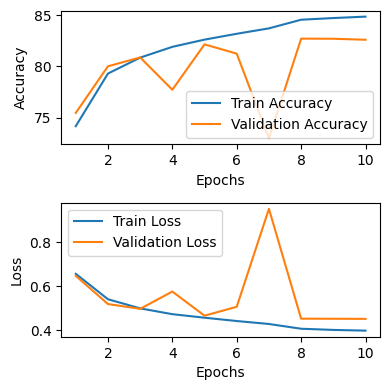

Accuracy of the model on the test set: 82.747%


In [ ]:
function_training(vocab_size, exp[4][0], exp[4][1], max_seq_len, exp[4][2], 5)

#### Transformer 6:
* Hidden dimension: 512
* Number of attention heads: 8
* Number of attention layers: 8


Epoch [1/10], Train Loss: 0.63553, Train Acc: 75.026%, Val Loss: 0.54435, Val Acc: 78.897% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.51980, Train Acc: 80.080%, Val Loss: 0.49849, Val Acc: 80.453% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.48109, Train Acc: 81.596%, Val Loss: 0.47801, Val Acc: 81.231% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.45512, Train Acc: 82.683%, Val Loss: 0.46049, Val Acc: 82.027% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.43684, Train Acc: 83.330%, Val Loss: 0.64868, Val Acc: 77.569% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.41826, Train Acc: 84.053%, Val Loss: 0.48892, Val Acc: 81.563% Learning Rate: 0.00100000
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
Epoch [7/10], Train Loss: 0.38858, Train Acc: 85.254%, Val Loss: 0.44998, Val Acc: 82.748% Learning Rate: 0.00010000
Epoch [8/10], Train Loss: 0.37955, Train Acc: 85.620%, Val Loss: 0.45093, Val Acc: 82.719% Learning Rate: 0.00010000
Ep

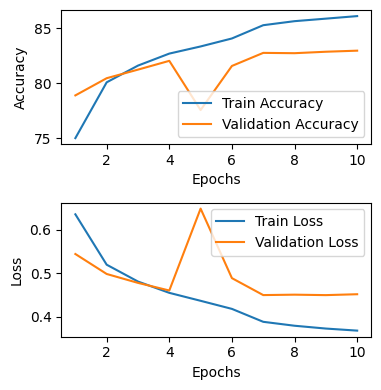

Accuracy of the model on the test set: 82.918%


In [ ]:
function_training(vocab_size, exp[5][0], exp[5][1], max_seq_len, exp[5][2], 6)

#### Transformer 7:
* Hidden dimension: 512
* Number of attention heads: 8
* Number of attention layers: 4


Epoch [1/10], Train Loss: 0.65935, Train Acc: 73.895%, Val Loss: 0.70763, Val Acc: 71.389% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.53443, Train Acc: 79.947%, Val Loss: 0.53712, Val Acc: 79.583% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.48704, Train Acc: 81.597%, Val Loss: 0.53743, Val Acc: 79.938% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.46308, Train Acc: 82.435%, Val Loss: 0.47086, Val Acc: 82.393% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.44147, Train Acc: 83.237%, Val Loss: 0.45689, Val Acc: 82.765% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.42581, Train Acc: 83.833%, Val Loss: 0.47865, Val Acc: 82.364% Learning Rate: 0.00100000
Epoch [7/10], Train Loss: 0.40870, Train Acc: 84.409%, Val Loss: 0.44250, Val Acc: 83.320% Learning Rate: 0.00100000
Epoch [8/10], Train Loss: 0.39456, Train Acc: 84.988%, Val Loss: 0.44755, Val Acc: 83.188% Learning Rate: 0.00100000
Epoch [9/10], Train Loss: 0.38040, Train Acc: 85.535%, Val Loss:

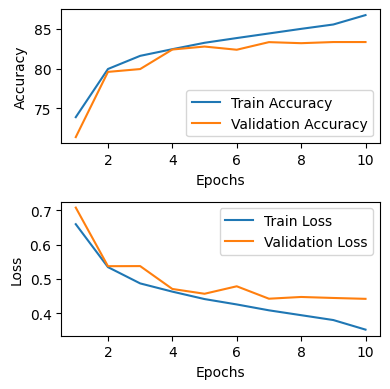

Accuracy of the model on the test set: 83.119%


In [ ]:
function_training(vocab_size, exp[6][0], exp[6][1], max_seq_len, exp[6][2], 7)


#### Transformer 8:
* Hidden dimension: 512
* Number of attention heads: 4
* Number of attention layers: 8


Epoch [1/10], Train Loss: 0.65818, Train Acc: 74.034%, Val Loss: 1.56303, Val Acc: 33.520% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.54587, Train Acc: 78.981%, Val Loss: 0.52113, Val Acc: 79.852% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.50388, Train Acc: 80.528%, Val Loss: 0.53794, Val Acc: 79.206% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.47666, Train Acc: 81.721%, Val Loss: 0.47898, Val Acc: 81.535% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.44915, Train Acc: 82.838%, Val Loss: 0.49580, Val Acc: 81.363% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.43290, Train Acc: 83.465%, Val Loss: 0.47062, Val Acc: 82.101% Learning Rate: 0.00100000
Epoch [7/10], Train Loss: 0.41255, Train Acc: 84.329%, Val Loss: 1.04728, Val Acc: 71.864% Learning Rate: 0.00100000
Epoch [8/10], Train Loss: 0.39708, Train Acc: 84.948%, Val Loss: 0.44196, Val Acc: 83.154% Learning Rate: 0.00100000
Epoch [9/10], Train Loss: 0.38217, Train Acc: 85.513%, Val Loss:

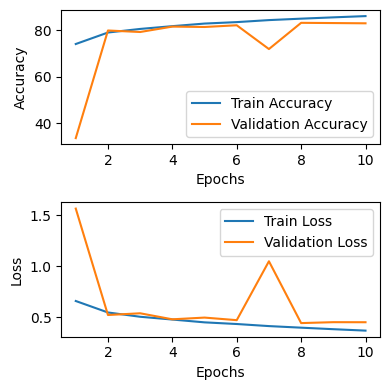

Accuracy of the model on the test set: 83.062%


In [ ]:
function_training(vocab_size, exp[7][0], exp[7][1], max_seq_len, exp[7][2], 8)


#### **Transformer 9: FINAL MODEL**:
* Hidden dimension: 512
* Number of attention heads: 16
* Number of attention layers: 16


Epoch [1/10], Train Loss: 0.59393, Train Acc: 76.758%, Val Loss: 0.58670, Val Acc: 77.707% Learning Rate: 0.00100000
Epoch [2/10], Train Loss: 0.48276, Train Acc: 81.585%, Val Loss: 0.49187, Val Acc: 80.928% Learning Rate: 0.00100000
Epoch [3/10], Train Loss: 0.44655, Train Acc: 83.045%, Val Loss: 0.46272, Val Acc: 82.507% Learning Rate: 0.00100000
Epoch [4/10], Train Loss: 0.42702, Train Acc: 83.773%, Val Loss: 0.94088, Val Acc: 65.078% Learning Rate: 0.00100000
Epoch [5/10], Train Loss: 0.41000, Train Acc: 84.369%, Val Loss: 0.45247, Val Acc: 82.616% Learning Rate: 0.00100000
Epoch [6/10], Train Loss: 0.39591, Train Acc: 84.926%, Val Loss: 0.44531, Val Acc: 82.977% Learning Rate: 0.00100000
Epoch [7/10], Train Loss: 0.37971, Train Acc: 85.658%, Val Loss: 0.46414, Val Acc: 83.297% Learning Rate: 0.00100000
Epoch [8/10], Train Loss: 0.36504, Train Acc: 86.194%, Val Loss: 0.45841, Val Acc: 83.366% Learning Rate: 0.00100000
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Ep

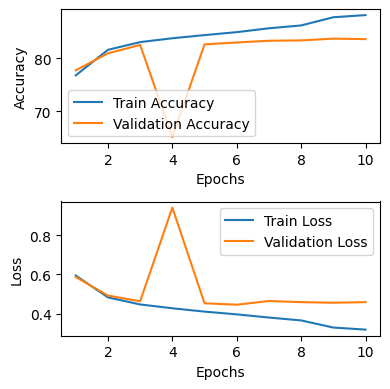

Accuracy of the model on the test set: 83.484%


In [ ]:
function_training(vocab_size, exp[8][0], exp[8][1], max_seq_len, exp[8][2], 9)


#### Transformer 10:
* Hidden dimension: 1024
* Number of attention heads: 16
* Number of attention layers: 16


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
Epoch [1/10], Train Loss: 0.71957, Train Acc: 70.801%, Val Loss: 0.62150, Val Acc: 76.110% Learning Rate: 0.00010000
Epoch [2/10], Train Loss: 0.57623, Train Acc: 78.118%, Val Loss: 0.55335, Val Acc: 79.023% Learning Rate: 0.00010000
Epoch [3/10], Train Loss: 0.52211, Train Acc: 80.190%, Val Loss: 0.51482, Val Acc: 80.224% Learning Rate: 0.00010000
Epoch [4/10], Train Loss: 0.49160, Train Acc: 81.337%, Val Loss: 0.59652, Val Acc: 75.778% Learning Rate: 0.00010000
Epoch [5/10], Train Loss: 0.47292, Train Acc: 82.021%, Val Loss: 0.48134, Val Acc: 81.792% Learning Rate: 0.00010000
Epoch [6/10], Train Loss: 0.45810, Train Acc: 82.560%, Val Loss: 0.48161, Val Acc: 81.775% Learning Rate: 0.00010000
Epoch [7/10], Train Loss: 0.44516, Train Acc: 83.062%, Val Loss: 0.61242, Val Acc: 78.588% Learning Rate: 0.00010000
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch [8/10], Train Loss: 0.42902, Train Acc: 83.715%, 

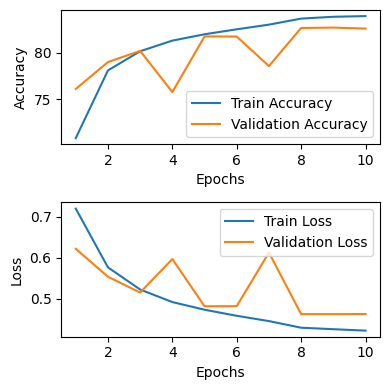

In [ ]:
%time
function_training(vocab_size, exp[9][0], exp[9][1], max_seq_len, exp[9][2], 10)

# Experiment 4: Transformer fine tuned on BERT

In [ ]:
# install transformers
!pip install transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
# Initialize a BERT tokenizer from the pre-trained model specified
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

100%|██████████| 174757/174757 [07:11<00:00, 405.12it/s]


<Axes: ylabel='Density'>

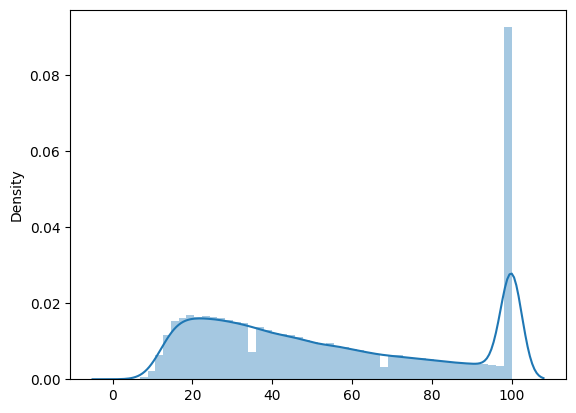

In [ ]:
# Loading pre-trained bert tokenizer
from tqdm import tqdm
token_lens = []
for txt in tqdm(train_df.preprocessed_review):
    tokens = tokenizer.encode(txt, max_length=100)
    token_lens.append(len(tokens))

sns.distplot(token_lens)


In [ ]:
MAX_LEN = 100

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews  # List of review texts
        self.tokenizer = tokenizer  # Tokenizer object
        self.max_len = max_len  # Maximum length of tokenized sequences
        # Mapping for labels to integers
        self.label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        # Convert target labels to numerical format using label_map
        self.targets = [self.label_map[label] for label in targets]

    def __len__(self):
        return len(self.reviews)  # Number of samples in the dataset

    def __getitem__(self, item):
        review = str(self.reviews[item])  # Get the review text at the specified index
        target = self.targets[item]  # Get the corresponding target label

        # Tokenize and encode the review using the provided tokenizer
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',  # Return PyTorch tensors
        )

        # Return a dictionary containing the processed review and its associated tokens
        return {
            'review_text': review,  # Original review text
            'input_ids': encoding['input_ids'].flatten(),  # Flattened input token IDs
            'attention_mask': encoding['attention_mask'].flatten(),  # Flattened attention mask
            'targets': torch.tensor(target, dtype=torch.long)  # Target label converted to PyTorch tensor
        }


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting into train and validation sets (70% train, 30% validation)
df_train, df_val = train_test_split(train_df, test_size=0.3, random_state=42)
df_test = test_df
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
print(df_train.columns)

(122329, 6)
(52428, 6)
(13980, 6)
Index(['text', 'stars', 'preprocessed_review', 'sentiment', 'padded_review',
       'label'],
      dtype='object')


In [ ]:
# 'balanced': This parameter specifies the strategy to compute class weights. Using 'balanced' means that the class weights will be inversely proportional to the class frequencies in the input data. It's a common strategy for dealing with imbalanced datasets.

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(df_train.sentiment.values), y = df_train.sentiment.values)

In [ ]:
class_weights

array([1.45282123, 3.37608324, 0.49615903])

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = ReviewDataset(
        reviews = df.preprocessed_review.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=4)

In [ ]:
# Creating Pytorch dataset loader
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Load the pre-trained BERT model specified by 'PRE_TRAINED_MODEL_NAME' without returning a dictionary output
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # Initializing BERT model for sentiment classification
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.4)  # Dropout layer
        self.out1 = nn.Linear(self.bert.config.hidden_size, 128)  # Linear layer 1
        self.drop1 = nn.Dropout(p=0.4)  # Dropout layer
        self.relu = nn.ReLU()  # ReLU activation function
        self.out = nn.Linear(128, n_classes)  # Final output layer for classification

    def forward(self, input_ids, attention_mask):
        # Forward pass through the sentiment classification model
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)  # Applying dropout
        output = self.out1(output)  # Linear transformation
        output = self.relu(output)  # Applying ReLU activation
        output = self.drop1(output)  # Applying dropout
        return self.out(output)  # Output prediction for classification


In [ ]:
# Creating a fine-tuned bert model
class_name = ['negative','positive','neutral']
fine_tuned_bert_model = SentimentClassifier(len(class_name))
fine_tuned_bert_model = fine_tuned_bert_model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
EPOCHS = 2  # Number of training epochs
optimizer = AdamW(fine_tuned_bert_model.parameters(), lr=2e-5, correct_bias=False)
# AdamW optimizer for fine-tuned BERT model with a learning rate of 2e-5 and no bias correction

total_steps = len(train_data_loader) * EPOCHS
# Total number of training steps (iterations) over all epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,  # No warmup steps
    num_training_steps=total_steps
)
# Scheduler for learning rate with linear decay and no warmup

loss_fn = nn.CrossEntropyLoss().to(device)
# Cross-entropy loss function for classification tasks, moved to the specified device (CPU or GPU)


In [ ]:
# Function to train one epoch of the model
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()  # Set the model to training mode
    losses = []  # List to store individual losses
    correct_predictions = 0  # Count of correct predictions

    for data in data_loader:  # Iterate through the data loader
        input_ids = data['input_ids'].to(device)  # Input IDs moved to the specified device
        attention_mask = data['attention_mask'].to(device)  # Attention mask moved to the specified device
        targets = data['targets'].to(device)  # Targets moved to the specified device

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)  # Get predictions by selecting the index of the maximum value
        loss = loss_fn(outputs, targets)  # Calculate the loss using the specified loss function

        correct_predictions += torch.sum(preds == targets)  # Count correct predictions
        losses.append(loss.item())  # Append the current loss value to the list of losses

        loss.backward()  # Backpropagation - compute gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to prevent exploding gradients
        optimizer.step()  # Update model parameters
        scheduler.step()  # Scheduler steps to adjust learning rate
        optimizer.zero_grad()  # Zero gradients for the next iteration

    # Calculate accuracy and average loss for the epoch
    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
# Function to evaluate the model on validation or test data
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()  # Set the model to evaluation mode
    losses = []  # List to store individual losses
    correct_predictions = 0  # Count of correct predictions

    with torch.no_grad():  # Turn off gradient calculation
        for d in data_loader:  # Iterate through the data loader
            input_ids = d["input_ids"].to(device)  # Move input IDs to the specified device
            attention_mask = d["attention_mask"].to(device)  # Move attention mask to the specified device
            targets = d["targets"].to(device)  # Move targets to the specified device

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)  # Get predictions by selecting the index of the maximum value
            loss = loss_fn(outputs, targets)  # Calculate the loss using the specified loss function

            correct_predictions += torch.sum(preds == targets)  # Count correct predictions
            losses.append(loss.item())  # Append the current loss value to the list of losses

    # Calculate accuracy and average loss for the evaluation
    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
from collections import defaultdict

# Dictionary to store training and validation history
history = defaultdict(list)

# Variable to store the best accuracy obtained during training
best_accuracy = 0

# Loop through the specified number of epochs
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model for one epoch and get training accuracy and loss
    train_acc, train_loss = train_epoch(
        fine_tuned_bert_model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Evaluate the model on the validation set and get validation accuracy and loss
    val_acc, val_loss = eval_model(
        fine_tuned_bert_model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Store training and validation metrics in the history dictionary
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save the model if the validation accuracy improves
    if val_acc > best_accuracy:
        torch.save(fine_tuned_bert_model.state_dict(), 'best_model_finetuned.bin')
        best_accuracy = val_acc  # Update the best accuracy


Epoch 1/2
----------
Train loss 0.3685430083847735 accuracy 0.8641614008125629
Val   loss 0.3261828817168047 accuracy 0.8744945448996719

Epoch 2/2
----------
Train loss 0.2652704867512658 accuracy 0.9027622231850175
Val   loss 0.32251337509263645 accuracy 0.8829251544975967



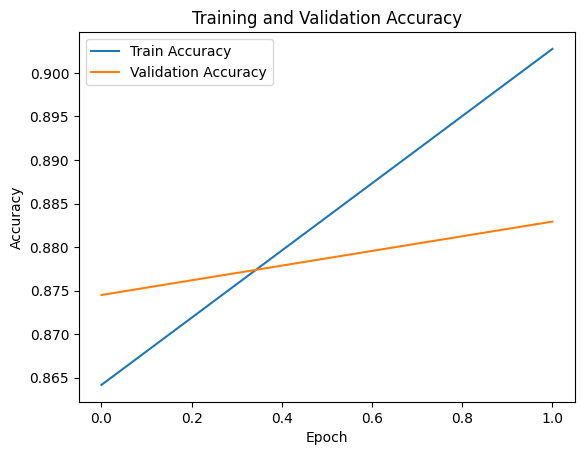

In [ ]:
import numpy as np

# Convert tensors to NumPy arrays on CPU
train_acc_cpu = np.array([tensor.item() for tensor in history['train_acc']])
val_acc_cpu = np.array([tensor.item() for tensor in history['val_acc']])

# Plotting accuracy values
plt.plot(train_acc_cpu, label='Train Accuracy')
plt.plot(val_acc_cpu, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluate the fine-tuned BERT model on the test set to compute the test accuracy
test_acc, _ = eval_model(
    fine_tuned_bert_model,  # The fine-tuned BERT model
    test_data_loader,  # Data loader for the test set
    loss_fn,  # Loss function used for evaluation
    device,  # Device (CPU or GPU) where the model is processed
    len(df_test)  # Total number of examples in the test set
)

# Extract the test accuracy value as a Python float
test_accuracy_value = test_acc.item()


0.8847639484978541

In [ ]:
# Function to get predictions and related values from the model on a given data loader
def get_predictions(model, data_loader):
    model = model.eval()  # Set the model to evaluation mode
    review_texts = []  # List to store review texts
    predictions = []  # List to store predicted labels
    prediction_probs = []  # List to store prediction probabilities
    real_values = []  # List to store true labels

    with torch.no_grad():  # Turn off gradient calculation
        for d in data_loader:  # Iterate through the data loader
            texts = d["review_text"]  # Get review texts
            input_ids = d["input_ids"].to(device)  # Move input IDs to the specified device
            attention_mask = d["attention_mask"].to(device)  # Move attention mask to the specified device
            targets = d["targets"].to(device)  # Move targets to the specified device

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)  # Get predictions by selecting the index of the maximum value
            review_texts.extend(texts)  # Add review texts to the list
            predictions.extend(preds)  # Add predicted labels to the list
            prediction_probs.extend(outputs)  # Add prediction probabilities to the list
            real_values.extend(targets)  # Add true labels to the list

    # Convert lists to tensors
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    # Return review texts, predicted labels, prediction probabilities, and true labels
    return review_texts, predictions, prediction_probs, real_values


In [ ]:
# Calling the get_predictions function to obtain predictions and related values
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    fine_tuned_bert_model,  # The fine-tuned BERT model
    test_data_loader  # Data loader for the test set
)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

    negative       0.85      0.89      0.87      3145
    positive       0.55      0.43      0.48      1416
     neutral       0.93      0.95      0.94      9419

    accuracy                           0.88     13980
   macro avg       0.78      0.76      0.77     13980
weighted avg       0.88      0.88      0.88     13980



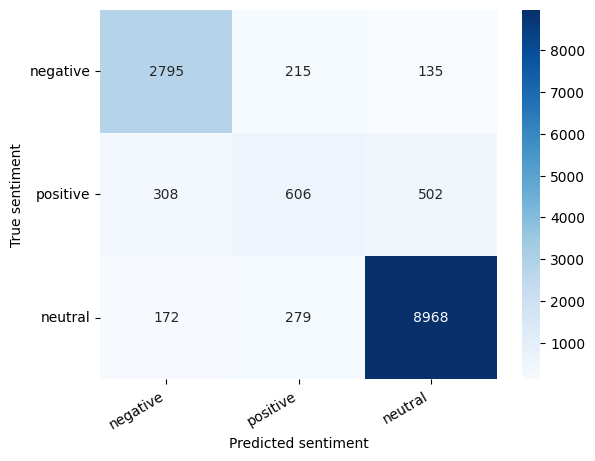

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

# Evaluation Metrics

In this section, we will load all the models that we created and evaluate their performance with respect to precision, accuracy, recall, f1 score and matthews_corrcoef for training and test dataset.

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def fun(modelx, X_train, y_train_encoded, X_test, y_test_encoded):
    # Load model
    model = load_model(modelx)
    model.summary()  # Print model summary

    # Make predictions on training data
    train_predictions = model.predict(X_train)
    train_predictions_classes = np.argmax(train_predictions, axis=-1)
    train_true_classes = np.argmax(y_train_encoded, axis=-1)

    # Calculate metrics for the training set
    train_accuracy = accuracy_score(train_true_classes, train_predictions_classes)
    train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(train_true_classes, train_predictions_classes, average=None)
    train_macro_precision = train_precision.mean()
    train_macro_recall = train_recall.mean()
    train_macro_f1 = train_f1_score.mean()
    train_mcc = matthews_corrcoef(train_true_classes, train_predictions_classes)
    print("Train Accuracy:", train_accuracy)
    print("Train Macro-Averaged Precision:", train_macro_precision)
    print("Train Macro-Averaged Recall:", train_macro_recall)
    print("Train Macro-Averaged F1 Score:", train_macro_f1)
    print("Train MCC:", train_mcc)

    # Make predictions on test data
    test_predictions = model.predict(X_test)
    test_predictions_classes = np.argmax(test_predictions, axis=-1)
    test_true_classes = np.argmax(y_test_encoded, axis=-1)

    # Calculate metrics for the test set
    test_accuracy = accuracy_score(test_true_classes, test_predictions_classes)
    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(test_true_classes, test_predictions_classes, average=None)
    test_macro_precision = test_precision.mean()
    test_macro_recall = test_recall.mean()
    test_macro_f1 = test_f1_score.mean()
    test_mcc = matthews_corrcoef(test_true_classes, test_predictions_classes)
    print("Test Accuracy:", test_accuracy)
    print("Test Macro-Averaged Precision:", test_macro_precision)
    print("Test Macro-Averaged Recall:", test_macro_recall)
    print("Test Macro-Averaged F1 Score:", test_macro_f1)
    print("Test MCC:", test_mcc)

    # Compute confusion matrix for training and test sets
    train_confusion = confusion_matrix(train_true_classes, train_predictions_classes)
    test_confusion = confusion_matrix(test_true_classes, test_predictions_classes)

    # Plot confusion matrices
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Train Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()


#### CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          2560000   
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 74, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                        

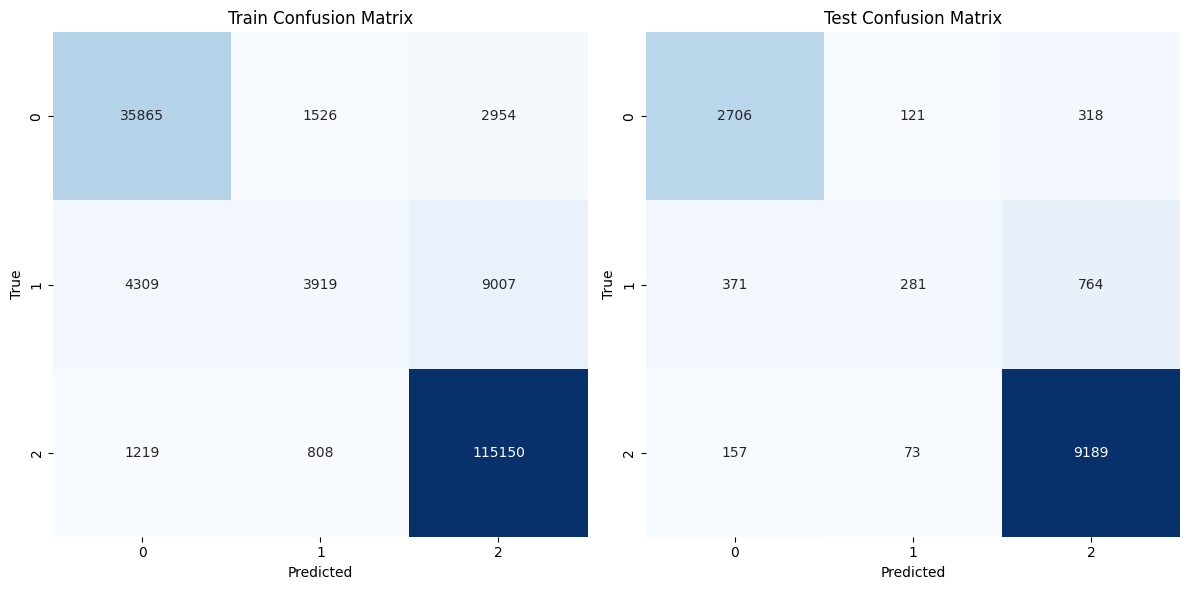

In [ ]:
fun('cnn.x', X_train, y_train_encoded, X_test, y_test_encoded)

#### RNN

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          640000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         49664     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                18560     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

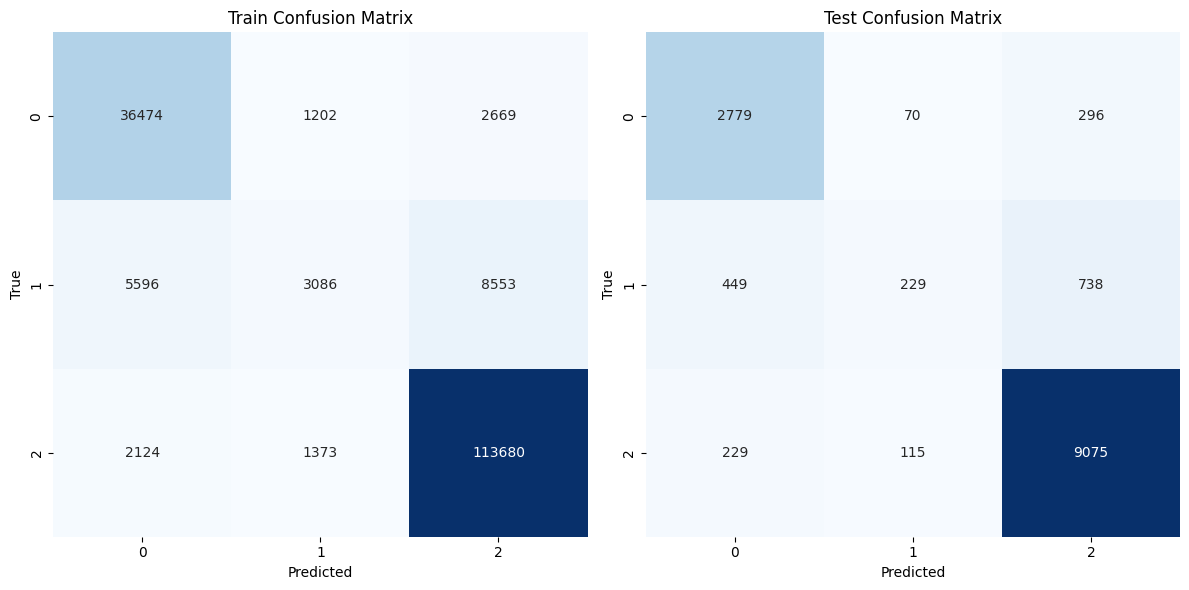

In [ ]:
fun('rnn.x', X_train, y_train_encoded, X_test, y_test_encoded)

#### Transformers

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

def fun_pytorch(model, device, train_loader, test_loader):

    # Set the model in evaluation mode
    model.eval()

    # Lists to store predictions and true labels
    train_predictions = []
    train_true_labels = []
    test_predictions = []
    test_true_labels = []

    # Evaluate on train data
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        train_predictions.extend(predicted.cpu().numpy())
        train_true_labels.extend(target.cpu().numpy())

    # Evaluate on test data
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        test_predictions.extend(predicted.cpu().numpy())
        test_true_labels.extend(target.cpu().numpy())

    # Compute metrics for train and test sets
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(train_true_labels, train_predictions, average=None)
    train_macro_precision = train_precision.mean()
    train_macro_recall = train_recall.mean()
    train_macro_f1 = train_f1_score.mean()
    train_confusion = confusion_matrix(train_true_labels, train_predictions)
    # Compute MCC for train and test sets
    train_mcc = matthews_corrcoef(train_true_labels, train_predictions)
    test_mcc = matthews_corrcoef(test_true_labels, test_predictions)

    test_accuracy = accuracy_score(test_true_labels, test_predictions)
    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average=None)
    test_macro_precision = test_precision.mean()
    test_macro_recall = test_recall.mean()
    test_macro_f1 = test_f1_score.mean()
    test_confusion = confusion_matrix(test_true_labels, test_predictions)

    # Print evaluation metrics
    print("Train Accuracy:", train_accuracy)
    print("Train Macro-Averaged Precision:", train_macro_precision)
    print("Train Macro-Averaged Recall:", train_macro_recall)
    print("Train Macro-Averaged F1 Score:", train_macro_f1)
    print("Train MCC:", train_mcc)

    print("Test Accuracy:", test_accuracy)
    print("Test Macro-Averaged Precision:", test_macro_precision)
    print("Test Macro-Averaged Recall:", test_macro_recall)
    print("Test Macro-Averaged F1 Score:", test_macro_f1)
    print("Test MCC:", test_mcc)

    # Plot confusion matrices
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Train Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()


Train Accuracy: 0.8060678542204318
Train Macro-Averaged Precision: 0.6772882596144383
Train Macro-Averaged Recall: 0.5627880073609002
Train Macro-Averaged F1 Score: 0.5525173109685816
Train MCC: 0.5685505047123284
Test Accuracy: 0.7954935622317597
Test Macro-Averaged Precision: 0.6565512420118299
Test Macro-Averaged Recall: 0.5547782531331963
Test Macro-Averaged F1 Score: 0.5426725668052407
Test MCC: 0.5411471806933986


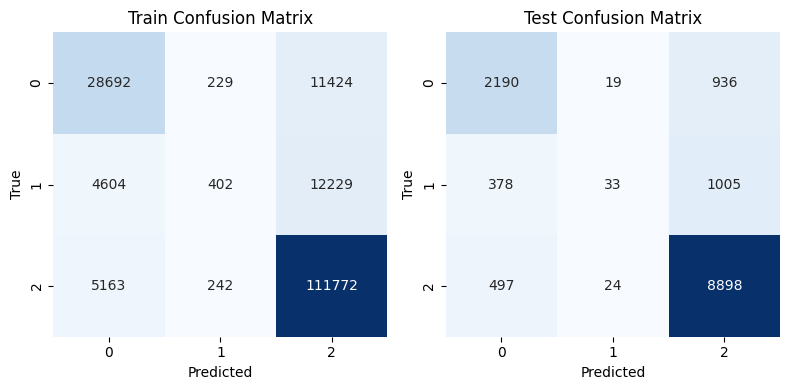

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[0][0], exp[0][1], max_seq_len, exp[0][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_1.pt'))  # Load the saved model state
model.to(device)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.8091750258930973
Train Macro-Averaged Precision: 0.6713143872504473
Train Macro-Averaged Recall: 0.5809116108134044
Train Macro-Averaged F1 Score: 0.5768933975459007
Train MCC: 0.5799120466428856
Test Accuracy: 0.8069384835479256
Test Macro-Averaged Precision: 0.6894606455047491
Test Macro-Averaged Recall: 0.5793602716382922
Test Macro-Averaged F1 Score: 0.5752940516175175
Test MCC: 0.5716328215217772


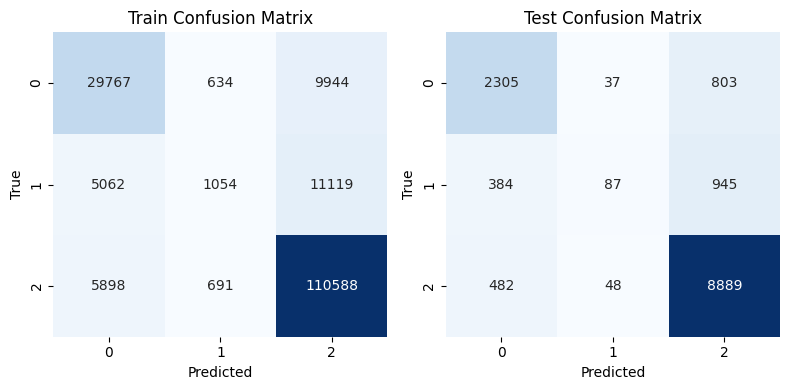

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[1][0], exp[1][1], max_seq_len, exp[1][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_2.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.7971354509404487
Train Macro-Averaged Precision: 0.6322533060713719
Train Macro-Averaged Recall: 0.5982071808705752
Train Macro-Averaged F1 Score: 0.5706734117946097
Train MCC: 0.5796581215621623
Test Accuracy: 0.7952074391988555
Test Macro-Averaged Precision: 0.6489736942448262
Test Macro-Averaged Recall: 0.593783023402912
Test Macro-Averaged F1 Score: 0.5684275637996531
Test MCC: 0.5686772452642598


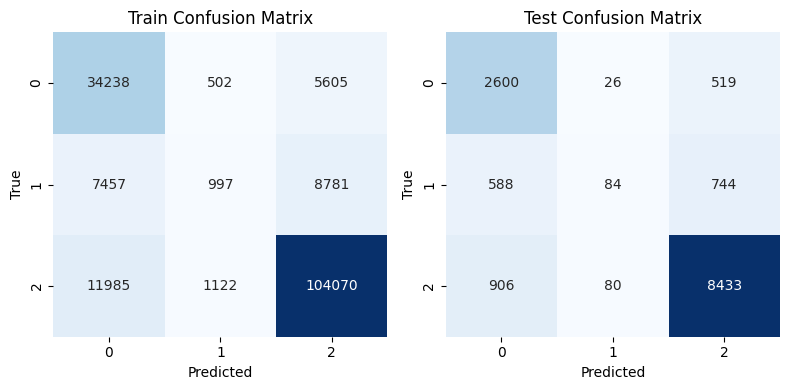

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[2][0], exp[2][1], max_seq_len, exp[2][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_3.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.8191088196753206
Train Macro-Averaged Precision: 0.6888104697988555
Train Macro-Averaged Recall: 0.6074161035714519
Train Macro-Averaged F1 Score: 0.6138211328875304
Train MCC: 0.6055459757820726
Test Accuracy: 0.813519313304721
Test Macro-Averaged Precision: 0.6792527058662935
Test Macro-Averaged Recall: 0.5983115556565632
Test Macro-Averaged F1 Score: 0.6042771697439717
Test MCC: 0.5888432782905404


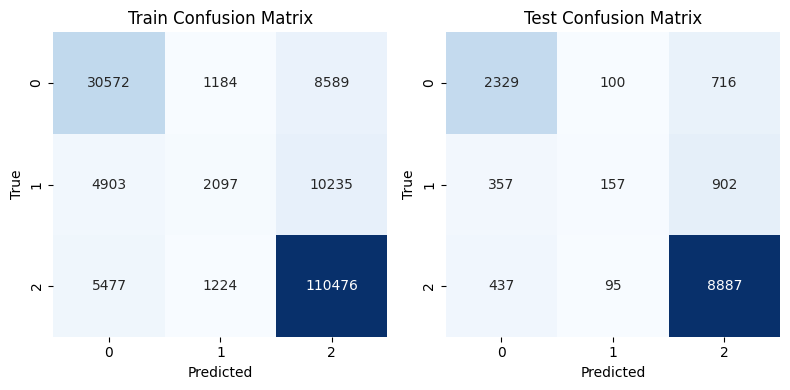

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[3][0], exp[3][1], max_seq_len, exp[3][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_4.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.845986140755449
Train Macro-Averaged Precision: 0.7294816676478901
Train Macro-Averaged Recall: 0.6413352691479414
Train Macro-Averaged F1 Score: 0.649420299503416
Train MCC: 0.6677294430693292
Test Accuracy: 0.8274678111587983
Test Macro-Averaged Precision: 0.7054377300149862
Test Macro-Averaged Recall: 0.6210496820326716
Test Macro-Averaged F1 Score: 0.6278712153774668
Test MCC: 0.6233066554988133


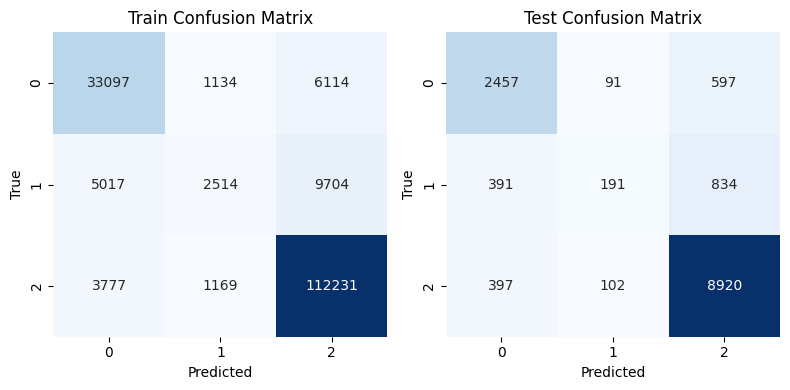

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[4][0], exp[4][1], max_seq_len, exp[4][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_5.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.8608238868829289
Train Macro-Averaged Precision: 0.7526716242789763
Train Macro-Averaged Recall: 0.6764927229466883
Train Macro-Averaged F1 Score: 0.6900106526554007
Train MCC: 0.7028641397194891
Test Accuracy: 0.8291845493562232
Test Macro-Averaged Precision: 0.7020147075364949
Test Macro-Averaged Recall: 0.6385593929666696
Test Macro-Averaged F1 Score: 0.647089028415553
Test MCC: 0.6310005692780779


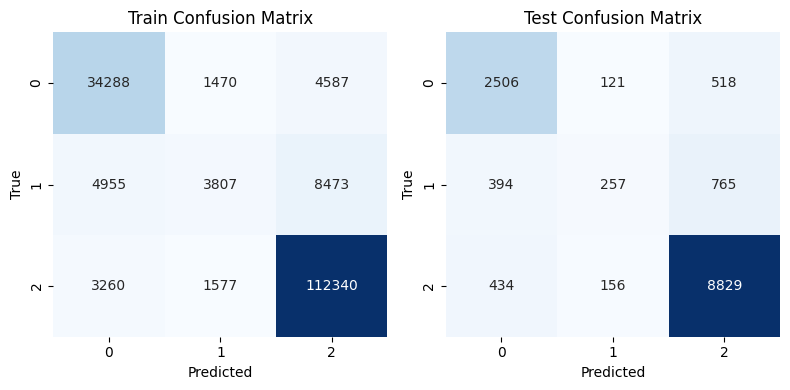

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[5][0], exp[5][1], max_seq_len, exp[5][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_6.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.8622773336690376
Train Macro-Averaged Precision: 0.7529176961261325
Train Macro-Averaged Recall: 0.6757479102994868
Train Macro-Averaged F1 Score: 0.6803520808110837
Train MCC: 0.7091523382469251
Test Accuracy: 0.8311874105865522
Test Macro-Averaged Precision: 0.6982837692539836
Test Macro-Averaged Recall: 0.6414923413708827
Test Macro-Averaged F1 Score: 0.6395633025965359
Test MCC: 0.6408348515730766


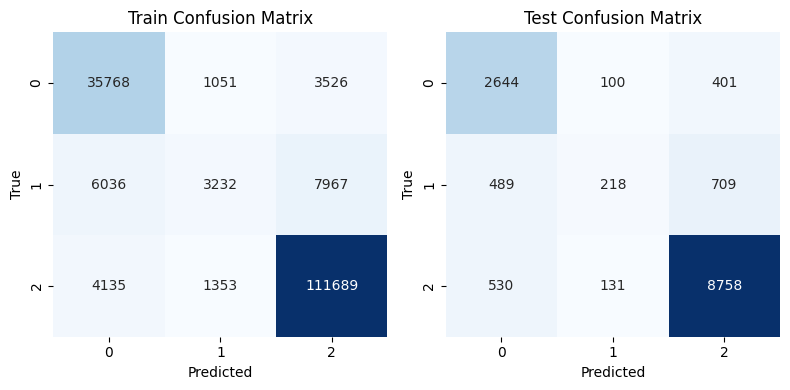

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[6][0], exp[6][1], max_seq_len, exp[6][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_7.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.8597938852234818
Train Macro-Averaged Precision: 0.7524823373200663
Train Macro-Averaged Recall: 0.6701361240709675
Train Macro-Averaged F1 Score: 0.6830592463883242
Train MCC: 0.7000224564087686
Test Accuracy: 0.8306151645207439
Test Macro-Averaged Precision: 0.7081601138241774
Test Macro-Averaged Recall: 0.6387847712305806
Test Macro-Averaged F1 Score: 0.6477809682170599
Test MCC: 0.633872809404061


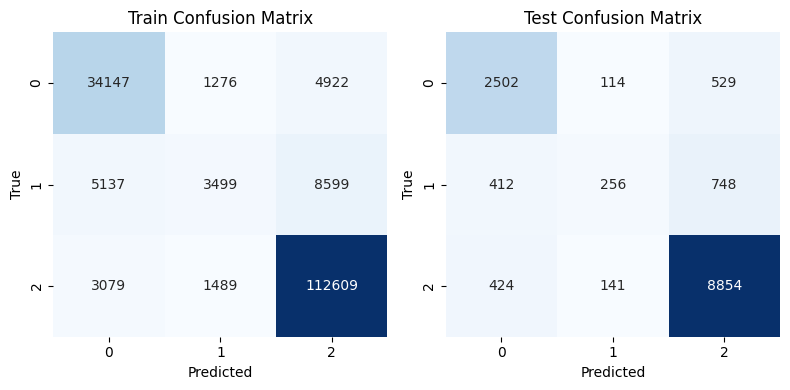

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[7][0], exp[7][1], max_seq_len, exp[7][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_8.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

Train Accuracy: 0.8390736851742706
Train Macro-Averaged Precision: 0.7136522919165014
Train Macro-Averaged Recall: 0.6384985913964276
Train Macro-Averaged F1 Score: 0.6400668253828081
Train MCC: 0.6555162614380441
Test Accuracy: 0.8258941344778254
Test Macro-Averaged Precision: 0.7007647868248612
Test Macro-Averaged Recall: 0.6279781730444235
Test Macro-Averaged F1 Score: 0.627414092246325
Test MCC: 0.6253017458886051


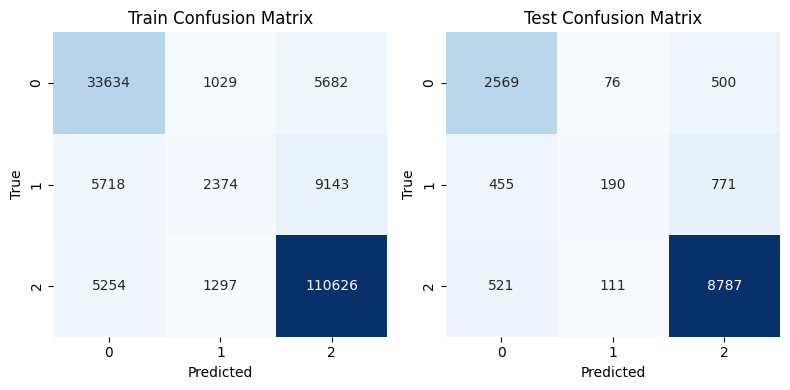

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[9][0], exp[9][1], max_seq_len, exp[9][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_10.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

#### **FINAL MODEL Evaluation**

Train Accuracy: 0.8760621892113049
Train Macro-Averaged Precision: 0.7907615869607048
Train Macro-Averaged Recall: 0.7049610807198818
Train Macro-Averaged F1 Score: 0.718498988042933
Train MCC: 0.7386225748492984
Test Accuracy: 0.8348354792560801
Test Macro-Averaged Precision: 0.7041143265574418
Test Macro-Averaged Recall: 0.645226671004529
Test Macro-Averaged F1 Score: 0.6472615988924709
Test MCC: 0.6466558694763026


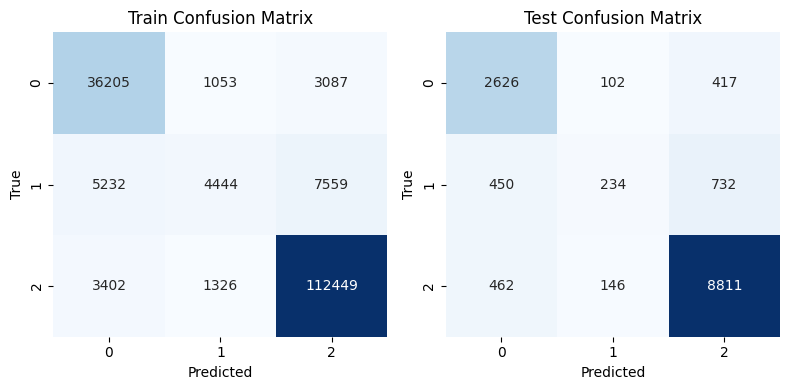

In [ ]:
transformer_encoder = TransformerEncoder(vocab_size, exp[8][0], exp[8][1], max_seq_len, exp[8][2])
model = TransformerClassifier(transformer_encoder, num_classes=3)
model.load_state_dict(torch.load('best_model_9.pt'))  # Load the saved model state
model.to(device)  # Move the model to the specified device (GPU or CPU)
fun_pytorch(model, device, train_loader, test_loader)

# Result analysis:
We concluded that as we increase the number of hidden layers in transformer, model performance improves to a certain extent and then starts decreasing. Increasing the number of attention heads and number of attention layers show significant improvement for all the metrics in general. Using transfer learning also proved to be helpful in our case which might indicate that our dataset was small to train a very powerful transformer from scratch. Nevertheless, we achieve 83.5% accuracy on test dataset with our final transformer model where hidden dimension is 512 and number of attention layers is 16.

# References
* https://medium.com/@lokaregns/effortless-sentiment-analysis-with-hugging-face-transformers-a-beginners-guide-359b0c8a1787
* https://www.kaggle.com/code/suzanaiacob/sentiment-analysis-of-the-yelp-reviews-data
* https://towardsdatascience.com/text-mining-and-sentiment-analysis-for-yelp-reviews-of-a-burger-chain-6d3bcfcab17b
* https://cs229.stanford.edu/proj2014/Yun%20Xu,%20Xinhui%20Wu,%20Qinxia%20Wang,%20Sentiment%20Analysis%20of%20Yelp's%20Ratings%20Based%20on%20Text%20Reviews.pdf
* https://urytrayudu1.medium.com/sentiment-analysis-for-yelp-review-classification-54b65c09ff7b
* https://paperswithcode.com/sota/text-classification-on-yelp-polarity
* https://github.com/huggingface/transformers
* https://github.com/dailyLi/yelp_da/tree/main
* https://github.com/ThinamXx/YelpReviews__Analysis/tree/main
* https://github.com/skshashankkumar41/Sentiment-Analysis-Using-Transformers-PyTorch/tree/master
* https://github.com/hbchen-one/Transformer-Models-from-Scratch/tree/main
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
